# Deep Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

import os
os.chdir(os.path.expanduser('../'))

from helper_functions import (train_and_evaluate_model, calculate_returns_for_model, 
                              daily_to_annual_returns, run_full_backtesting)

In [2]:
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Cross validation to calculate optimal number of months

In [4]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

In [5]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'DNN Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months, flatten=True)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Input(shape=x_train.shape[1:]),
            Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

DNN Model for 3 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3897898030019903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.4257097041388115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sharpe fold 0.3869504500577524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3941185386224068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sharpe fold 0.3805617081293637
Mean Sharpe 0.395426040790065
DNN Model for 4 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.39685424450198764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sharpe fold 0.3801702351987671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.39011656326519784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sharpe fold 0.38784413106991367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sharpe fold 0.3709406832320672
Mean Sharpe 0.38518517145358666
DNN Model for 5 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sharpe fold 0.3989922499821888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.39698106735397715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [15]:
best_month_no = 7

x = data_provider.get_formatted_features(no_months=best_month_no, flatten=True)
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

## Hiperparameters Tuning

In [16]:
def build_model(hp):
    model = Sequential((
            Input(shape=x_train.shape[1:]),
            Dense(hp.Choice('units', [32, 64, 128]), 
                  activation='relu', 
                  kernel_regularizer=L2(hp.Choice('reg', [0.1, 0.2, 0.3]))),
            Dense(y_train.shape[1], activation='softmax')
        ))
    model.compile(loss='mse')
    return model

In [17]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,
    directory='tuning',
    project_name='model_dnn')

Reloading Tuner from tuning\model_dnn\tuner0.json


In [18]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
reg (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}


In [19]:
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val))

In [20]:
tuner.results_summary()

Results summary
Results in tuning\model_dnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 005 summary
Hyperparameters:
units: 32
reg: 0.1
Score: 0.0006120444741100073

Trial 002 summary
Hyperparameters:
units: 64
reg: 0.1
Score: 0.0006198793416842818

Trial 001 summary
Hyperparameters:
units: 32
reg: 0.2
Score: 0.000641599006485194

Trial 007 summary
Hyperparameters:
units: 64
reg: 0.2
Score: 0.0006595276645384729

Trial 006 summary
Hyperparameters:
units: 32
reg: 0.3
Score: 0.0006828571786172688

Trial 003 summary
Hyperparameters:
units: 64
reg: 0.3
Score: 0.0007151876343414187

Trial 008 summary
Hyperparameters:
units: 128
reg: 0.1
Score: 0.0007432918064296246

Trial 004 summary
Hyperparameters:
units: 128
reg: 0.3
Score: 0.0007968738209456205

Trial 000 summary
Hyperparameters:
units: 128
reg: 0.2
Score: 0.0008713951101526618


In [21]:
# best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Dense(64, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

## Best Model training

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,915 (54.36 KB)

 Trainable params: 13,915 (54.36 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.3364 - val_loss: 8.3990 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1168 - val_loss: 7.2742 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0224 - val_loss: 6.2736 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0506 - val_loss: 5.3914 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1955 - val_loss: 4.6186 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4477 - val_loss: 3.9454 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7965 - val_loss: 3.3613 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2330 - val_loss: 2.8562 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7451 - val_loss: 2.4207 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

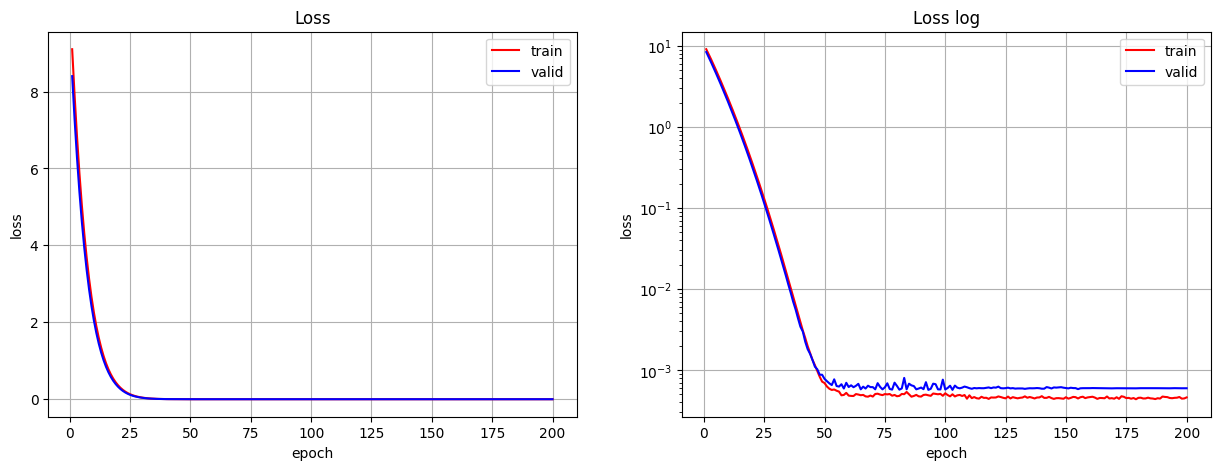

In [22]:
train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


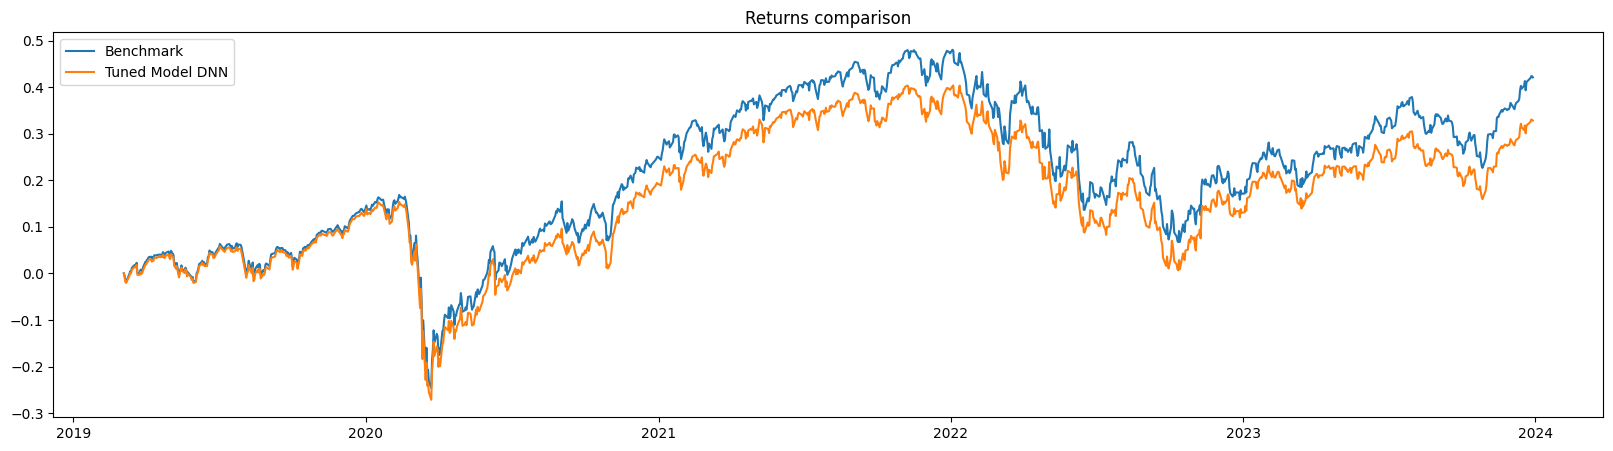

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Model DNN,0.061348,0.201991,0.303718,0.351582,-0.368188,499.0,0.166623,-0.561688


In [23]:
models = {'Tuned Model DNN': (best_model, x_test)}
df_results = run_full_backtesting(data_provider, models)
df_results